## !Important to do this first to have the effnetv2 model installed!

In [1]:
%%capture
#@title
!pip install tensorflow_addons

import os
import sys
import tensorflow.compat.v1 as tf

# Download source code.
if "efficientnetv2" not in os.getcwd():
    !git clone --depth 1 https://github.com/google/automl
    os.chdir('automl/efficientnetv2')
    sys.path.append('.')
else:
    !git pull

def download(m):
    if m not in os.listdir():
        !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/{m}.tgz
        !tar zxf {m}.tgz
    ckpt_path = os.path.join(os.getcwd(), m)
    return ckpt_path

## Import my funcs and other necessary libraries

In [2]:
import EfficientNet_Functions as myfuncs

In [3]:
import tensorflow_hub as hub
import itertools
import os

import matplotlib.pylab as plt
import numpy as np
import csv
import PIL
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

## Configs

In [4]:
data_dir_train = '/projectnb/dl523/projects/Sarcasm/content/gdrive/Shareddrives/520 Project/Data/wikipaintings_full_aug/train'
data_dir_val = '/projectnb/dl523/projects/Sarcasm/wikipaintings_full/wikipaintings_val'
data_dir_test = '/projectnb/dl523/projects/Sarcasm/wikipaintings_full/wikipaintings_test'
data_dir_test_aug = '/projectnb/dl523/projects/Sarcasm/content/gdrive/Shareddrives/520 Project/Data/wikipaintings_full_aug/test'

IMAGE_SIZE = 223
BATCH_SIZE =  32
LEARNING_RATE = 0.001

## Load data

Loading data...

Found 7383 images belonging to 25 classes.
Found 246350 images belonging to 25 classes.
Found 8201 images belonging to 25 classes.
Label map:
{'Abstract_Art': 0, 'Abstract_Expressionism': 1, 'Art_Informel': 2, 'Art_Nouveau_(Modern)': 3, 'Baroque': 4, 'Color_Field_Painting': 5, 'Cubism': 6, 'Early_Renaissance': 7, 'Expressionism': 8, 'High_Renaissance': 9, 'Impressionism': 10, 'Magic_Realism': 11, 'Mannerism_(Late_Renaissance)': 12, 'Minimalism': 13, 'Naive_Art_(Primitivism)': 14, 'Neoclassicism': 15, 'Northern_Renaissance': 16, 'Pop_Art': 17, 'Post-Impressionism': 18, 'Realism': 19, 'Rococo': 20, 'Romanticism': 21, 'Surrealism': 22, 'Symbolism': 23, 'Ukiyo-e': 24}


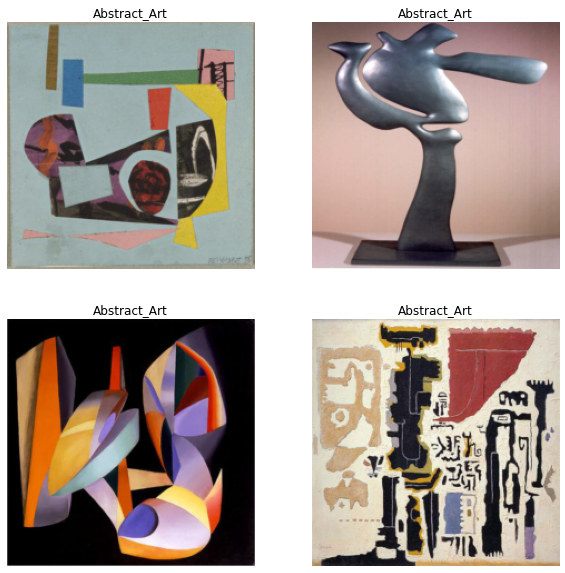

In [5]:
_,_,test_generator = myfuncs.load_wikidata(data_dir_train, data_dir_val, data_dir_test,
                                                                batch_size = BATCH_SIZE, image_size = IMAGE_SIZE)

myfuncs.visualize_input(test_generator)

Loading data...

Found 7383 images belonging to 25 classes.
Found 246350 images belonging to 25 classes.
Found 8201 images belonging to 25 classes.
Label map:
{'Abstract_Art': 0, 'Abstract_Expressionism': 1, 'Art_Informel': 2, 'Art_Nouveau_(Modern)': 3, 'Baroque': 4, 'Color_Field_Painting': 5, 'Cubism': 6, 'Early_Renaissance': 7, 'Expressionism': 8, 'High_Renaissance': 9, 'Impressionism': 10, 'Magic_Realism': 11, 'Mannerism_(Late_Renaissance)': 12, 'Minimalism': 13, 'Naive_Art_(Primitivism)': 14, 'Neoclassicism': 15, 'Northern_Renaissance': 16, 'Pop_Art': 17, 'Post-Impressionism': 18, 'Realism': 19, 'Rococo': 20, 'Romanticism': 21, 'Surrealism': 22, 'Symbolism': 23, 'Ukiyo-e': 24}


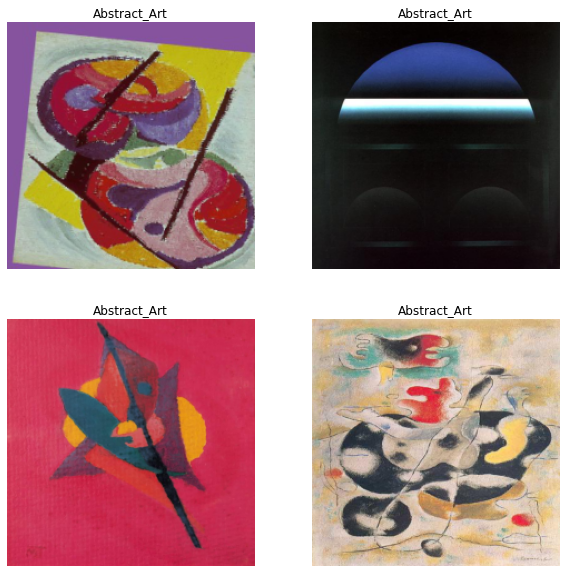

In [6]:
_,_,testaug_generator = myfuncs.load_wikidata(data_dir_train, data_dir_val, data_dir_test_aug,
                                                                batch_size = BATCH_SIZE, image_size = IMAGE_SIZE)

myfuncs.visualize_input(testaug_generator)

## Load trained model

In [7]:
checkpoint_path = "/projectnb/dl523/students/nannkat/EC520/training/cp_unfreeze" + str(16) + ".ckpt"
model = myfuncs.restore_model(checkpoint_path, learning_rate = LEARNING_RATE, compile_m = True)

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (EffNetV2M  (None, 1280)             117746848 
 odel)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 25)                32025     
                                                                 
Total params: 117,778,873
Trainable params: 32,025
Non-trainable params: 117,746,848
_________________________________________________________________


## Evaluate - non-augmented

In [8]:
test_steps = test_generator.samples // test_generator.batch_size
model.evaluate(test_generator, steps = test_steps)

256/256 [==============================] - 186s 689ms/step - loss: 1.5109 - accuracy: 0.6650 - top_3_categorical_accuracy: 0.8926 - top_k_categorical_accuracy: 0.9520


[1.5109319686889648, 0.6650390625, 0.892578125, 0.9520263671875]

## Evaluate - augmented

In [9]:
testaug_steps = testaug_generator.samples // testaug_generator.batch_size
model.evaluate(testaug_generator, steps = testaug_steps)

256/256 [==============================] - 140s 547ms/step - loss: 1.6214 - accuracy: 0.6267 - top_3_categorical_accuracy: 0.8640 - top_k_categorical_accuracy: 0.9318


[1.621433973312378, 0.626708984375, 0.864013671875, 0.9317626953125]

## Example augmented/non-augmented predictions

In [18]:
image, label = next(test_generator)
image = image[0, :, :, :]
true_index = np.argmax(label[0])        
prediction_scores = model(np.expand_dims(image, axis=0))
preds_nums = prediction_scores.numpy().astype(float).tolist()[0]

In [27]:
print()
print("Example output: ")
print()
preds_nums_dict = {}
for i, prob in enumerate(preds_nums):
    preds_nums_dict[i] = prob

preds_nums_sorted = {k: v for k, v in sorted(preds_nums_dict.items(), key=lambda item: item[1], reverse = True)}

for i, (key, val) in enumerate(preds_nums_sorted.items()):
    print("{}. class {}: {}".format(i +1 , key, val))    

print()
print("Label map")
print(test_generator.class_indices)


Example output: 

1. class 2: 0.8529024720191956
2. class 8: 0.03697267919778824
3. class 1: 0.023678261786699295
4. class 18: 0.018235282972455025
5. class 0: 0.013177434913814068
6. class 5: 0.009491858072578907
7. class 3: 0.00858007837086916
8. class 19: 0.007457524072378874
9. class 10: 0.004395130556076765
10. class 7: 0.0032758822198957205
11. class 20: 0.002700512297451496
12. class 14: 0.00238147284835577
13. class 23: 0.0022544567473232746
14. class 24: 0.002050210954621434
15. class 22: 0.0018142402404919267
16. class 11: 0.0016111815348267555
17. class 15: 0.0016007156809791923
18. class 4: 0.0011706484947353601
19. class 21: 0.0011349101550877094
20. class 12: 0.0011142726289108396
21. class 9: 0.0010505645768716931
22. class 6: 0.0009723137482069433
23. class 16: 0.0008972018258646131
24. class 13: 0.0006929386872798204
25. class 17: 0.0003877522540278733

Label map
{'Abstract_Art': 0, 'Abstract_Expressionism': 1, 'Art_Informel': 2, 'Art_Nouveau_(Modern)': 3, 'Baroque': 

In [ ]:
myfuncs.visualize_results(model, test_generator)

In [ ]:
myfuncs.visualize_results(model, testaug_generator)

## Predict and save .csv

In [21]:
output_path = '/projectnb/dl523/students/nannkat/EC520/preds_vs_true_effnet_OGdata.csv'
preds, true_labels, preds_df = myfuncs.predict_and_save(model, test_generator, output_path)

Predicting....
256/257 [============================>.] - ETA: 8s 

In [23]:
output_path = '/projectnb/dl523/students/nannkat/EC520/preds_vs_true_effnet_augdata.csv'
preds_aug, true_labels_aug, preds_df_aug = myfuncs.predict_and_save(model, testaug_generator, output_path)

Predicting....
256/257 [============================>.] - ETA: 8s 